# Clasificación de Residuos

Como modelo preentrenado, usaremos una **Inception Resnet**, que a pesar de ser más pesada que **MobileNet**, nos puede ofrecer mejores resultados, y de cara al deployment resulta bastante óptima. A partir de este modelo preentrenado, incluiremos nuestro conjunto de datos con residuos etiquetados por tipos de residuos.

## Importar Librerías

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
import numpy as np
from keras.models import save_model

## Carga de Datos

In [ ]:
# Usamos el respositorio de GitHub para facilitar la carga de Datos.
!git clone "https://github.com/cienciadatos/EDM_Project.git"
!unzip "EDM_Project/garbage_data.zip"

In [3]:
import os
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)
for file in files_in_directory:
    print(file)

.config
one-indexed-files-notrash_test.txt
zero-indexed-files.txt
one-indexed-files-notrash_val.txt
Garbage classification
one-indexed-files.txt
one-indexed-files-notrash_train.txt
EDM_Project
garbage classification
sample_data


In [5]:
imagen_train, imagen_val = ('Garbage classification/Garbage classification/',
                            'Garbage classification/Garbage classification/')

In [7]:
import cv2
ruta_imagen = imagen_train + "glass/glass1.jpg"

imagen = cv2.imread(ruta_imagen)
alto, ancho, canales = imagen.shape

print("Alto:", alto)
print("Ancho:", ancho)
print("Canales:", canales)

Alto: 384
Ancho: 512
Canales: 3


## Preprocesado

In [10]:
# PARA EL CONJUNTO DE ENTRENAMIENTO
train_data = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory= imagen_train,
               target_size=(224,224),
               classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
               batch_size=32,
               subset='training',
               seed=16)

Found 2276 images belonging to 6 classes.


In [11]:
# PARA EL CONJUNTO DE VALIDACIÓN
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.inception_resnet_v2.preprocess_input  ,
    validation_split=0.1).flow_from_directory(
    directory= imagen_val,
               target_size=(224,224),
               classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
               batch_size=32,
               subset='validation',
               seed=16)

Found 251 images belonging to 6 classes.


La función `Image Generator` es muy importante y sirve para crear batches de imágenes con transformaciones de datos (*Data Augmentation*). Es una forma sencilla de "preprocesar" los datos de una manera automatizada.

Parámetros:
1. `preprocessing_function_`: función de procesamiento específica de la red usada.
2. `zoom_range`: una de las transformaciones de aumento de datos. Cambia la escala de la imagen, acercándola y alejándoka (0.2 sería ampliar o reducir en un 20%, por ejemplo).
3. `width_shift_range` y `height_shift_range`: desplazamiento horizontal y vertical.
4. `validation_split`: porcentaje de datos para validación.
5. `flow_from_directory`: genera los datos a partir del directorio que contiene las imágenes de entrenamiento. Se le pasa el `target_size` a 224x224 porque *ResNet* usa ese tamaño.

## Modelo
Cargamos el modelo con la arquitectura de **ResNet**, preentrenada con la base de datos de **ImageNet**.

Parámetros:

1. `include_top`: indica que se incluye la *fully conected* del final en el modelo. Si es False, no se incluyen las capas de clasificación y solo se incluyen las capas de extracción de características (las CNN). Habitualmete, se pone a False para entrenar un MLP que clasifique según nuestros datos.
2. `weights`: se indica la base de datos y se cargan los pesos preentrenados con esa base de datos.
3. `pooling`: indica si se realiza pooling o no en la última capa de la red. Si es None, la salida es un tensor tridimensional en lugar de bidimensional.

### Construcción del Modelo

Creamos un modelo con la clase `Sequential` y le añadimos la base del modelo **ResNet** (*modelo_preentrenado*).

Congelamos la base de la red preentrenada (`modelo_preentrenado.trainable=False`). Este parámetro evita que los pesos de la base del modelo *InceptionResNetV2* se actualicen durante el entrenamiento. Esto significa que solo se entrenarán los pesos de las capas añadidas a posteriori.

`GlobalAveragePooling2D`: esta capa realiza un promedio  de las características en la salida de la base del modelo *InceptionResNetV2*, reduciendo la dimensionalidad de los datos. Este paso es fundamental para pasarlo a la capa *fully conected*.

Una vez aplano los datos, creamos una MLP para clasificar la salida de la ResNet. Empezamos con una capa de 512 neuronas, reducimos a 128 y la capa de salida es una softmax de 6 neuronas (una por cada clase) que devuelve un vector con la probabilidad de clasificación de cada clase.

In [12]:
modelo_preentrenado = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(224,224,3), include_top=False,
    weights='imagenet', pooling=None,
    )

modelo_preentrenado.trainable=False

model = Sequential()
model.add(modelo_preentrenado)
model.add(GlobalAveragePooling2D())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=6, activation='softmax'))

219055592/219055592 [==============================] - 7s 0us/step


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization_203 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

En el modelo tenemos 54 millones de parámetros no entrenables, que corresponden a ResNet y 854.662 entrenables, que corresponden perceptrón multicapa.

### Compilar el Modelo

Establecemos la función de pérdida, en este caso `categorical_crossentropy` ya que tenemos 6 clases categóricas. Además, definimos el solver (SGD), su `learning_rate` y la métrica que usaremos para evaluar el modelo, que en este caso será el `accuracy`.  

In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

### Callbacks del Modelo

#### Learning Rate

Creamos un *callback* para reducir el *learning rate* conforme avanza el entrenamiento. Esto es importante para que la red mejore y no caiga en un mínimo/máximo local.

Parámetros:

1. `monitor`: métrica utilizada para monitorear y decidir si se debe reducir la tasa de aprendizaje.
2. `factor`: factor por el cual se reduce la tasa de aprendizaje. En este caso, se reduce un 10% si se activa
3. `patience`: número de *epochs* que se esperará sin mejoras en la métrica antes de reducir la tasa de aprendizaje.
5. `mode`: especifica si se debe activar la reducción de la tasa de aprendizaje cuando la métrica monitoreada deja de mejorar ('auto'), cuando se produce una disminución ('min') o cuando se produce un aumento ('max').
6. `epsilon`: el umbral que se utiliza para determinar si hay una mejora significativa en la métrica.

In [16]:
controlador_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                               patience=15,
                               verbose=1,
                               mode='auto',
                               min_delta=0.001)

#### Early Stopping

El otro *callback* utilizado durante el entrenamiento del modelo es *EarlyStopping*, que sirve para detener el entrenamiento cuando una métrica específica deja de mejorar.

In [17]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=50)

In [18]:
callbacks = [controlador_lr,stop]

### Entrenamiento del Modelo

Definimos cuantos pasos va a tener cada una de los *epochs*. Se lleva a cabo acorde al número de *batches* y a la cantidad de imágenes de cada batch, por que si no, podría definirse un número de pasos muy alto y no tener suficientes imágenes para el entrenamiento.



In [ ]:
steps_per_epoch = train_data.samples/train_data.batch_size
steps_per_val = valid_batches.samples/valid_batches.batch_size

history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_batches,
    validation_steps=steps_per_val,
    verbose=1,
    callbacks = callbacks)

Epoch 1/30
71/71 [==============================] - 58s 590ms/step - loss: 2.6070 - accuracy: 0.1683 - val_loss: 2.0318 - val_accuracy: 0.2351 - lr: 1.0000e-04
Epoch 2/30
71/71 [==============================] - 36s 504ms/step - loss: 2.3676 - accuracy: 0.2039 - val_loss: 1.8890 - val_accuracy: 0.2470 - lr: 1.0000e-04
Epoch 3/30
71/71 [==============================] - 36s 508ms/step - loss: 2.2618 - accuracy: 0.2355 - val_loss: 1.7657 - val_accuracy: 0.3028 - lr: 1.0000e-04
Epoch 4/30
71/71 [==============================] - 36s 504ms/step - loss: 2.1080 - accuracy: 0.2755 - val_loss: 1.6525 - val_accuracy: 0.3506 - lr: 1.0000e-04
Epoch 5/30
71/71 [==============================] - 36s 507ms/step - loss: 1.9366 - accuracy: 0.3247 - val_loss: 1.5433 - val_accuracy: 0.4143 - lr: 1.0000e-04
Epoch 6/30
71/71 [==============================] - 37s 516ms/step - loss: 1.8470 - accuracy: 0.3427 - val_loss: 1.4507 - val_accuracy: 0.4781 - lr: 1.0000e-04
Epoch 7/30
71/71 [======================

#### Evaluación

Mostramos por pantalla una gráfica comparativa del modelo (train y validation) en relación a la función de pérdida y a la métrica utilizada, para ver su evolución a lo largo del entrenamiento.

In [ ]:
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

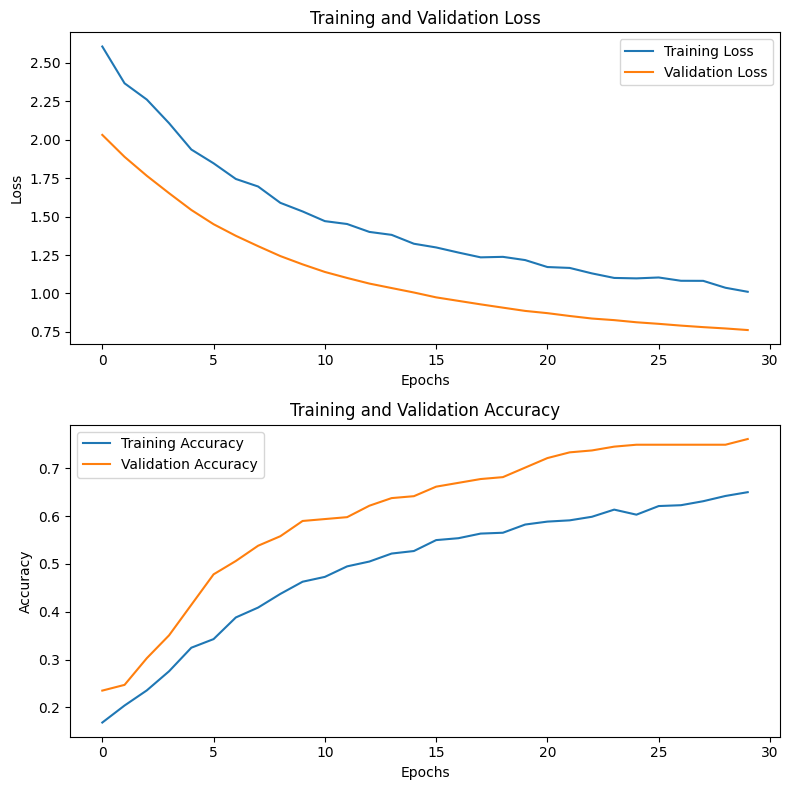

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## Predicción

1/1 [==============================] - 0s 58ms/step


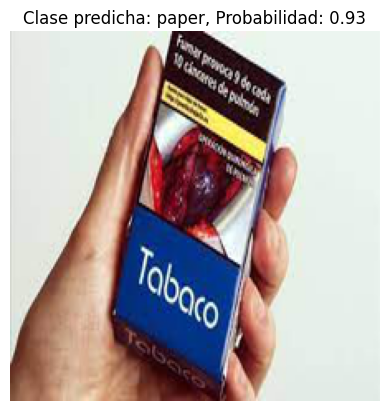

In [ ]:
import requests
from PIL import Image
from io import BytesIO

labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def prediccion(image_path, model):
    image = Image.open(image_path)
    image = image.resize((224, 224))

    imagen_preprocesada = tf.keras.applications.inception_resnet_v2.preprocess_input(np.array(image))

    imagen_preprocesada = np.expand_dims(imagen_preprocesada, axis=0)

    predicciones = model.predict(imagen_preprocesada)

    indice_clase_predicha = np.argmax(predicciones[0])
    clase_predicha = labels[indice_clase_predicha]
    prob = predicciones[0][indice_clase_predicha]

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Clase predicha: {clase_predicha}, Probabilidad: {prob:.2f}')
    plt.show()

# Descargar una imagen de internet y ponerla en la ruta del notebook
# para probar la predicción.
image_path = 'imagen.jpeg'
prediccion(image_path, model)

## Guardar el Modelo

Guardamos el modelo para ponerlo en producción usando la aplicación de `Streamlit`.

In [ ]:
acc = validation_accuracy[-1]
accuracy_str = str(round(acc, 2))  # Guarda el valor con 2 decimales

# Definir la carpeta y el nombre de archivo
folder = 'modelos'
model_name = 'model_accuracy_{}.h5'.format(accuracy_str)

import os
if not os.path.exists(folder):
    os.makedirs(folder)
model_path = os.path.join(folder, model_name)
save_model(model, model_path)